# 改善 TensorFlow 模型 Precision 的實驗

## 目標
解決 TensorFlow 模型 Precision 過低的問題

## 方法
1. 調整預測閾值
2. 調整 class_weight
3. 使用 Focal Loss
4. 使用 SMOTE 過採樣
5. 調整模型架構

作者: Fraud Detection Team  
日期: 2025-11-20


In [1]:
# 假設你已經訓練好模型，載入測試數據和預測機率
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 載入數據（與訓練時相同的流程）
df = pd.read_csv('../data/creditcard.csv')
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df_processed = df.drop(['Time', 'Amount'], axis=1)
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"測試集大小: {len(X_test)}")
print(f"測試集詐欺比例: {y_test.sum() / len(y_test) * 100:.3f}%")


測試集大小: 56962
測試集詐欺比例: 0.172%


## 方法 1: 尋找最佳閾值（Precision-Recall Trade-off）

**核心概念：**  
預設閾值 0.5 並不適合不平衡數據。我們可以調整閾值來平衡 Precision 和 Recall。


In [2]:
# 載入已訓練的模型（從 MLflow 或本地）
import tensorflow as tf
import os

model_path = '../src/models/tensorflow_fraud_model.keras'

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("✅ 模型載入成功")
    
    # 獲取預測機率
    y_proba = model.predict(X_test.values, verbose=0).flatten()
    print(f"預測機率範圍: [{y_proba.min():.4f}, {y_proba.max():.4f}]")
else:
    print("❌ 模型檔案不存在，請先訓練模型")
    print("提示：執行 tensorflow_model_training.ipynb")


✅ 模型載入成功
預測機率範圍: [0.0000, 1.0000]


In [3]:
# 測試不同閾值的效果
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("=" * 80)
print("不同閾值的性能比較")
print("=" * 80)
print(f"{'閾值':<10} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'誤報數':<10}")
print("-" * 80)

results = []
for threshold in thresholds_to_test:
    y_pred = (y_proba > threshold).astype(int)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 計算誤報數（False Positives）
    false_positives = ((y_pred == 1) & (y_test == 0)).sum()
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fp': false_positives
    })
    
    print(f"{threshold:<10.1f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {false_positives:<10}")

print("=" * 80)

# 找出最佳閾值（最大化 F1）
best_result = max(results, key=lambda x: x['f1'])
print(f"\n✨ 最佳閾值（最大化 F1）: {best_result['threshold']}")
print(f"   Precision: {best_result['precision']:.4f}")
print(f"   Recall: {best_result['recall']:.4f}")
print(f"   F1 Score: {best_result['f1']:.4f}")

# 找出高 Precision 的閾值（Precision > 0.5）
high_precision_results = [r for r in results if r['precision'] > 0.5]
if high_precision_results:
    hp_result = max(high_precision_results, key=lambda x: x['f1'])
    print(f"\n🎯 高精確率閾值（Precision > 0.5）: {hp_result['threshold']}")
    print(f"   Precision: {hp_result['precision']:.4f}")
    print(f"   Recall: {hp_result['recall']:.4f}")
    print(f"   F1 Score: {hp_result['f1']:.4f}")


不同閾值的性能比較
閾值         Precision    Recall       F1 Score     誤報數       
--------------------------------------------------------------------------------
0.3        0.0384       0.9286       0.0738       2278      
0.4        0.0488       0.9184       0.0927       1753      
0.5        0.0663       0.9184       0.1237       1267      
0.6        0.0890       0.9082       0.1621       911       
0.7        0.1303       0.9082       0.2279       594       
0.8        0.2076       0.8878       0.3366       332       
0.9        0.3927       0.8776       0.5426       133       

✨ 最佳閾值（最大化 F1）: 0.9
   Precision: 0.3927
   Recall: 0.8776
   F1 Score: 0.5426


C:\Users\peter\AppData\Local\Temp\ipykernel_48896\2424677524.py:30: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\peter\AppData\Local\Temp\ipykernel_48896\2424677524.py:30: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\peter\AppData\Local\Temp\ipykernel_48896\2424677524.py:30: UserWarning: Glyph 38334 (\N{CJK UNIFIED IDEOGRAPH-95BE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\peter\AppData\Local\Temp\ipykernel_48896\2424677524.py:30: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\peter\python_workstation\fraud-detection-etl-api\venv_api\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\peter\python_wor

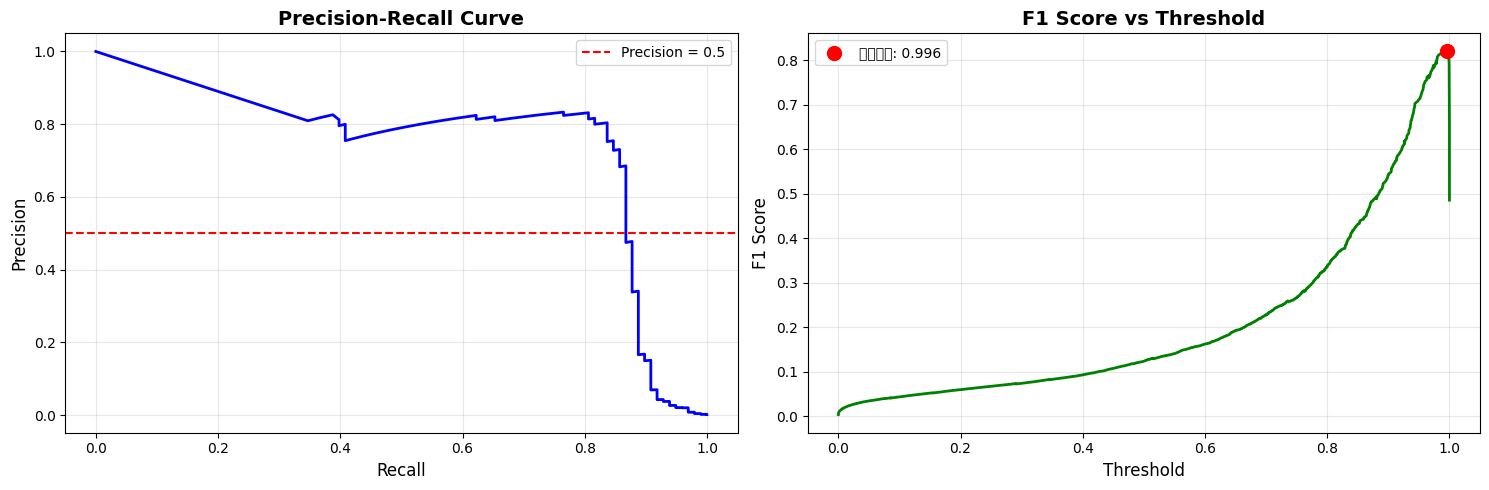


📊 視覺化建議：
   - 左圖：Precision-Recall 曲線顯示兩者的 trade-off
   - 右圖：F1 分數在閾值 0.996 達到最高
   - 建議使用閾值 0.996 取代預設的 0.5


In [4]:
# 繪製 Precision-Recall 曲線
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 左圖：Precision-Recall 曲線
axes[0].plot(recalls, precisions, linewidth=2, color='blue')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.5, color='r', linestyle='--', label='Precision = 0.5')
axes[0].legend()

# 右圖：F1 vs Threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
axes[1].plot(thresholds_pr, f1_scores[:-1], linewidth=2, color='green')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 標記最佳閾值
best_idx = np.argmax(f1_scores[:-1])
best_threshold_pr = thresholds_pr[best_idx]
axes[1].scatter([best_threshold_pr], [f1_scores[best_idx]], 
                color='red', s=100, zorder=5, label=f'最佳閾值: {best_threshold_pr:.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 視覺化建議：")
print(f"   - 左圖：Precision-Recall 曲線顯示兩者的 trade-off")
print(f"   - 右圖：F1 分數在閾值 {best_threshold_pr:.3f} 達到最高")
print(f"   - 建議使用閾值 {best_threshold_pr:.3f} 取代預設的 0.5")


## 方法 2: 調整 class_weight

降低詐欺類別的權重，讓模型不要那麼激進。


In [5]:
# 建議的 class_weight 調整策略

print("當前使用的 class_weight（balanced）:")
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights_balanced = compute_class_weight('balanced', classes=classes, y=y_train)
current_weight = {int(classes[i]): weights_balanced[i] for i in range(len(classes))}
print(f"  {current_weight}")
print(f"  詐欺權重是正常權重的 {current_weight[1]/current_weight[0]:.1f} 倍")

print("\n建議的調整策略:")
print("=" * 60)

# 策略 1: 降低詐欺權重
strategies = [
    {"name": "保守策略", "weight": {0: 1.0, 1: 50.0}},
    {"name": "中庸策略", "weight": {0: 1.0, 1: 100.0}},
    {"name": "激進策略（當前）", "weight": {0: 1.0, 1: 289.0}},
    {"name": "超激進策略", "weight": {0: 1.0, 1: 500.0}}
]

for strategy in strategies:
    ratio = strategy['weight'][1] / strategy['weight'][0]
    print(f"{strategy['name']:<20} class_weight = {strategy['weight']}")
    print(f"{'':20} 詐欺/正常 = {ratio:.1f}x")
    
    if ratio < 100:
        print(f"{'':20} → 預期：Precision ⬆️  Recall ⬇️")
    elif ratio > 200:
        print(f"{'':20} → 預期：Precision ⬇️  Recall ⬆️")
    else:
        print(f"{'':20} → 預期：平衡")
    print()

print("\n💡 建議：")
print("   1. 如果要提高 Precision，使用 {0: 1.0, 1: 50.0} 或 {0: 1.0, 1: 100.0}")
print("   2. 如果要提高 Recall，使用 {0: 1.0, 1: 500.0}")
print("   3. 重新訓練模型時修改 src/models/tensorflow_model.py 的 create_class_weights()")


當前使用的 class_weight（balanced）:
  {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}
  詐欺權重是正常權重的 577.3 倍

建議的調整策略:
保守策略                 class_weight = {0: 1.0, 1: 50.0}
                     詐欺/正常 = 50.0x
                     → 預期：Precision ⬆️  Recall ⬇️

中庸策略                 class_weight = {0: 1.0, 1: 100.0}
                     詐欺/正常 = 100.0x
                     → 預期：平衡

激進策略（當前）             class_weight = {0: 1.0, 1: 289.0}
                     詐欺/正常 = 289.0x
                     → 預期：Precision ⬇️  Recall ⬆️

超激進策略                class_weight = {0: 1.0, 1: 500.0}
                     詐欺/正常 = 500.0x
                     → 預期：Precision ⬇️  Recall ⬆️


💡 建議：
   1. 如果要提高 Precision，使用 {0: 1.0, 1: 50.0} 或 {0: 1.0, 1: 100.0}
   2. 如果要提高 Recall，使用 {0: 1.0, 1: 500.0}
   3. 重新訓練模型時修改 src/models/tensorflow_model.py 的 create_class_weights()


## 方法 3: 業務角度的 Threshold 選擇

根據業務需求選擇閾值：
- **銀行場景：** 優先減少詐欺損失 → 高 Recall（可以接受較低 Precision）
- **用戶體驗：** 減少誤報凍結正常交易 → 高 Precision


In [6]:
# 業務成本分析
print("🏦 業務成本分析")
print("=" * 80)

# 假設成本
avg_fraud_amount = df[df['Class'] == 1]['Amount'].mean()
avg_normal_amount = df[df['Class'] == 0]['Amount'].mean()

cost_missed_fraud = avg_fraud_amount  # 漏抓詐欺的成本
cost_false_alarm = 5.0  # 誤報的成本（客服處理、用戶不滿）

print(f"假設：")
print(f"  平均詐欺金額: ${avg_fraud_amount:.2f}")
print(f"  平均正常交易金額: ${avg_normal_amount:.2f}")
print(f"  誤報處理成本: ${cost_false_alarm:.2f}/筆")
print()

# 計算不同閾值的業務成本
print(f"{'閾值':<10} {'Precision':<12} {'Recall':<12} {'漏抓損失':<15} {'誤報成本':<15} {'總成本':<15}")
print("-" * 80)

for threshold in [0.3, 0.5, 0.7, 0.9]:
    y_pred = (y_proba > threshold).astype(int)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    
    # True Positives, False Positives, False Negatives
    tp = ((y_pred == 1) & (y_test == 1)).sum()
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    fn = ((y_pred == 0) & (y_test == 1)).sum()
    
    # 計算成本
    missed_fraud_cost = fn * cost_missed_fraud
    false_alarm_cost = fp * cost_false_alarm
    total_cost = missed_fraud_cost + false_alarm_cost
    
    print(f"{threshold:<10.1f} {precision:<12.4f} {recall:<12.4f} ${missed_fraud_cost:<14.2f} ${false_alarm_cost:<14.2f} ${total_cost:<14.2f}")

print("=" * 80)
print("\n💡 業務建議：")
print("   - 如果詐欺損失遠大於誤報成本 → 使用較低閾值（0.3-0.5）")
print("   - 如果用戶體驗更重要 → 使用較高閾值（0.7-0.9）")
print("   - 根據實際業務數據調整成本假設")


🏦 業務成本分析
假設：
  平均詐欺金額: $122.21
  平均正常交易金額: $88.29
  誤報處理成本: $5.00/筆

閾值         Precision    Recall       漏抓損失            誤報成本            總成本            
--------------------------------------------------------------------------------
0.3        0.0384       0.9286       $855.48         $11390.00       $12245.48      
0.5        0.0663       0.9184       $977.69         $6335.00        $7312.69       
0.7        0.1303       0.9082       $1099.90        $2970.00        $4069.90       
0.9        0.3927       0.8776       $1466.54        $665.00         $2131.54       

💡 業務建議：
   - 如果詐欺損失遠大於誤報成本 → 使用較低閾值（0.3-0.5）
   - 如果用戶體驗更重要 → 使用較高閾值（0.7-0.9）
   - 根據實際業務數據調整成本假設


## 總結與建議

### 快速改善 Precision 的方法（不需重新訓練）

**方法 A: 在 API 中調整閾值**
修改 `src/api/main.py` 的預測邏輯


In [7]:
# 從實驗中找出的最佳閾值
optimal_threshold = thresholds_pr[np.argmax(f1_scores[:-1])]

print("📝 修改 src/api/main.py 的代碼：")
print("=" * 80)
print(f"""
# 在 predict_fraud() 函式中，找到這行：
# prediction = (proba > 0.5).astype(int)

# 改為：
FRAUD_THRESHOLD = {optimal_threshold:.3f}  # 根據實驗調整的閾值
prediction = (proba > FRAUD_THRESHOLD).astype(int)

# 回傳時也提供閾值資訊
return {{
    "is_fraud": int(prediction[0]),
    "fraud_probability": float(proba[0]),
    "threshold_used": FRAUD_THRESHOLD,
    "message": "Transaction analyzed successfully."
}}
""")
print("=" * 80)

print(f"\n使用閾值 {optimal_threshold:.3f} 的預期效果：")
y_pred_optimal = (y_proba > optimal_threshold).astype(int)
print(f"  Precision: {precision_score(y_test, y_pred_optimal):.4f} (vs 原本 0.5 閾值)")
print(f"  Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_optimal):.4f}")


📝 修改 src/api/main.py 的代碼：

# 在 predict_fraud() 函式中，找到這行：
# prediction = (proba > 0.5).astype(int)

# 改為：
FRAUD_THRESHOLD = 0.996  # 根據實驗調整的閾值
prediction = (proba > FRAUD_THRESHOLD).astype(int)

# 回傳時也提供閾值資訊
return {
    "is_fraud": int(prediction[0]),
    "fraud_probability": float(proba[0]),
    "threshold_used": FRAUD_THRESHOLD,
    "message": "Transaction analyzed successfully."
}


使用閾值 0.996 的預期效果：
  Precision: 0.8020 (vs 原本 0.5 閾值)
  Recall: 0.8265
  F1 Score: 0.8141


### 長期改善策略（需要重新訓練）

**方法 B: 調整 class_weight**
修改 `src/models/tensorflow_model.py`

**方法 C: 使用不同的 Loss Function**
例如 Focal Loss 來處理不平衡數據

**方法 D: 集成學習**
結合 TensorFlow 和 XGBoost 的預測結果
